<a href="https://colab.research.google.com/github/khangsheng1/Learning-PyTorch/blob/main/CC_Fraud_Kaggle/CC_Fraud_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

Kaggle dataset is found [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

## Load libraries and data into notebook

In [1]:
import os
import torch
import torch.nn as nn
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!kaggle datasets download -d mlg-ulb/creditcardfraud -p ./datasets/

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Define the path to your zip file
zip_file_path = './datasets/creditcardfraud.zip'
extracted_path = './datasets/extracted/'

# Check if the file exists
if os.path.exists(zip_file_path):
    # Open the zip file in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents of the zip file to a directory
        zip_ref.extractall(extracted_path)
        print(f'Files extracted to: {extracted_path}')
else:
    print("Zip file does not exist.")

Files extracted to: ./datasets/extracted/


In [4]:
# Assuming there's a CSV file in the extracted folder
csv_file_path = os.path.join(extracted_path, 'creditcard.csv')

# Load the CSV into a pandas DataFrame
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
    print(df.head())  # Print the first 5 rows of the DataFrame
else:
    print("CSV file not found.")

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

## Get information about dataset


*   Shape
*   Statistics
*   Visualize data




In [5]:
print(f'The titles of each column are:\n\n{df.columns}\n\n\n')
print(f'The shape of the dataset is:\n\n{df.shape}\n\n\n')


The titles of each column are:

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')



The shape of the dataset is:

(284807, 31)





In [6]:
print(f'The simple statistics of the dataset are:\n\n')
df.describe()

The simple statistics of the dataset are:




,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# Proportion of dataset (how many entries are fraud and how many are not)
num_nonfraud = df['Class'].value_counts()[0]
num_fraud = df['Class'].value_counts()[1]
num_entries = len(df)

# Proportion of dataset (how many entries are fraud and how many are not)
proportion_nonfraud = (num_nonfraud / num_entries) * 100
proportion_fraud = (num_fraud / num_entries) *100

print(f'Proportion of non-fraudulent entries: {proportion_nonfraud:.2f}%, Count: {num_nonfraud}')
print(f'Proportion of fraudulent entries: {proportion_fraud:.2f}%, Count: {num_fraud}')

Proportion of non-fraudulent entries: 99.83%, Count: 284315
Proportion of fraudulent entries: 0.17%, Count: 492


### Visualize propotion of data

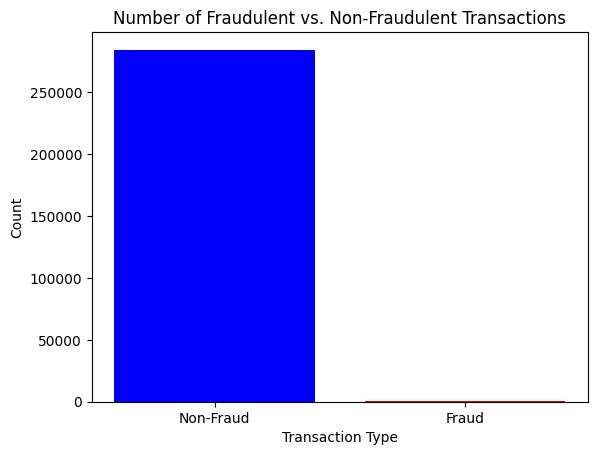

In [8]:
# Create a bar plot
plt.bar(['Non-Fraud', 'Fraud'], [num_nonfraud, num_fraud], color=['blue', 'red'])

# Add labels and title
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Number of Fraudulent vs. Non-Fraudulent Transactions')

# Display the plot
plt.show()

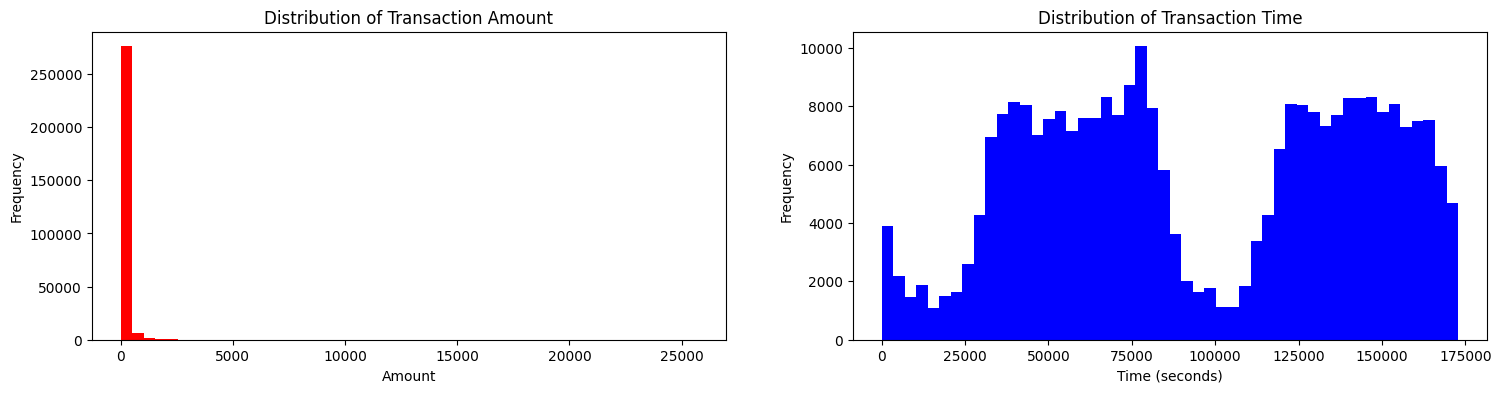

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))  # 1 row, 2 columns of plots

# Histogram for 'Amount'
ax[0].hist(df['Amount'], bins=50, color='r')  # Adjust 'bins' as needed
ax[0].set_title('Distribution of Transaction Amount')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

# Histogram for 'Time'
ax[1].hist(df['Time'], bins=50, color='b')  # Adjust 'bins' as needed
ax[1].set_title('Distribution of Transaction Time')
ax[1].set_xlabel('Time (seconds)')
ax[1].set_ylabel('Frequency')

plt.show()  # Display the plots

## Scaling and distribution

Since all the V's are scaled, we should do the same for 'Time' and 'Amount' so they don't influence the neural network too much.

Since there are so many non-fraud cases, we undersample as we don't want to overfit based on those entries.

### Scaling

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# StandardScaler: Scales data by removing the mean and scaling to unit variance.
# RobustScaler: Scales data using statistics that are robust to outliers.
# RobustScaler is preferred here because it's less sensitive to outliers in the data.

# Initialize both StandardScaler and RobustScaler objects.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# Create new dataframe to manipulate
df_scal_dist = []
df_scal_dist = df.copy()

# Apply RobustScaler to 'Amount' and 'Time' columns.
df_scal_dist['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df_scal_dist['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Remove original 'Time' and 'Amount' columns.
df_scal_dist.drop(['Time','Amount'], axis=1, inplace=True)

# Print first 5 rows of new data
df_scal_dist.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


### Undersampling

In [11]:
# Make new dataframes for fraud cases and non fraud cases where we undersample
# non fraud cases to match the number of fraud cases.
fraud_df = []
non_fraud_df = []
fraud_df = df_scal_dist.loc[df['Class'] == 1]
non_fraud_df = df_scal_dist.loc[df['Class'] == 0]

# Shuffle non fraud dataframe and subsample the number of fraud cases out
non_fraud_df = non_fraud_df.sample(frac=1)
non_fraud_df = non_fraud_df.sample(len(fraud_df))

# Combine fraud and nonfraud data frames and shuffle
new_df = []
new_df = pd.concat([fraud_df, non_fraud_df])
new_df = new_df.sample(frac=1)

# Print new dataframe
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
74507,-7.427924,2.948209,-8.678550,5.185303,-4.761090,-0.957095,-7.773380,0.717309,-3.682359,-8.403150,...,0.610479,0.789023,-0.564512,0.201196,-0.111225,1.144599,0.102280,1,1.515266,-0.341569
154380,0.140853,1.125872,-0.264716,-0.340834,0.980725,-0.714511,0.860504,-0.154084,1.269744,-1.208036,...,-1.014372,0.120481,0.477099,-0.468387,0.078733,0.196979,0.077009,0,-0.244673,0.195738
14211,-17.275191,10.819665,-20.363886,6.046612,-13.465033,-4.166647,-14.409448,11.580797,-4.073856,-9.153368,...,-1.208096,-0.726839,0.112540,1.119193,-0.233189,1.684063,0.503740,1,1.089779,-0.698293
43589,1.025543,-0.530751,0.336535,-0.050730,-0.607209,-0.007470,-0.375540,0.220260,0.329556,-0.020230,...,-0.399291,0.009171,-0.291112,-0.030898,0.900369,-0.085763,0.006643,0,1.078320,-0.506620
6446,0.702710,2.426433,-5.234513,4.416661,-2.170806,-2.667554,-3.878088,0.911337,-0.166199,-5.009249,...,-0.009802,0.721698,0.473246,-1.959304,0.319476,0.600485,0.129305,1,-0.293440,-0.904851


In [12]:
# Separate into X and y
X = new_df.drop(columns=['Class'])
y = new_df['Class']

# Check the shape of X and y to ensure they're correct
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (984, 30)
Labels shape: (984,)


## Split test into training and testing set (80/20)

In [13]:
# Perform an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the DataFrames to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

# Check the shapes of the tensors
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: torch.Size([787, 30])
X_test shape: torch.Size([197, 30])
y_train shape: torch.Size([787])
y_test shape: torch.Size([197])


## Check if cuda is avaliable to run and set data set to device

In [14]:
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}.')

You are using cpu.


In [15]:
# Move tensors to the appropriate device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Verify the device of the tensors
print(f"X_train is on: {X_train.device}")
print(f"X_test is on: {X_test.device}")
print(f"y_train is on: {y_train.device}")
print(f"y_test is on: {y_test.device}")

X_train is on: cpu
X_test is on: cpu
y_train is on: cpu
y_test is on: cpu


## Build neural network model

In [16]:
# Build model

class CC_Fraud_Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features) # Output should be 1 for binary classification
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create instance of model
# Change the output_features to 1 for binary classification
model = CC_Fraud_Model(input_features=X_test.shape[1],output_features=1,hidden_units=20)
model.to(device)
print(model)
print(f"Model is on: {next(model.parameters()).device}")

CC_Fraud_Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Model is on: cpu


## Loss function and optimizer

In [17]:
# Create loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

## Create accuracy function

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## Train model

In [19]:
torch.manual_seed(42)
epochs = 450
epoch_print = epochs/10

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []
epoch_count = []

for epoch in range(epochs):

  # Put model in training mode
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze() # squeeze to remove extra dimension
  y_pred = torch.round(torch.sigmoid(y_logits)) # ensure y_pred and y_train have the same shape

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) # y_logits and y_train should now have compatible shapes
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing

  # Put model into evaluation mode
  model.eval()

  with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze() # squeeze to remove extra dimension
      test_pred = torch.round(torch.sigmoid(test_logits))# ensure test_pred and y_test have the same shape
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)# test_logits and y_test should now have compatible shapes
      test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)


  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    train_acc_values.append(acc)
    test_acc_values.append(test_acc)
  if epoch % epoch_print == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.62941, Accuracy: 80.81% | Test Loss: 0.61919, Test Acc: 82.23%
Epoch: 45 | Loss: 0.49548, Accuracy: 88.06% | Test Loss: 0.48627, Test Acc: 87.82%
Epoch: 90 | Loss: 0.45859, Accuracy: 88.95% | Test Loss: 0.44817, Test Acc: 89.85%
Epoch: 135 | Loss: 0.43363, Accuracy: 91.74% | Test Loss: 0.42359, Test Acc: 90.36%
Epoch: 180 | Loss: 0.41304, Accuracy: 92.50% | Test Loss: 0.40426, Test Acc: 90.36%
Epoch: 225 | Loss: 0.39476, Accuracy: 93.01% | Test Loss: 0.38774, Test Acc: 89.85%
Epoch: 270 | Loss: 0.37833, Accuracy: 93.27% | Test Loss: 0.37299, Test Acc: 89.85%
Epoch: 315 | Loss: 0.36338, Accuracy: 93.39% | Test Loss: 0.35965, Test Acc: 90.36%
Epoch: 360 | Loss: 0.34973, Accuracy: 93.14% | Test Loss: 0.34745, Test Acc: 90.86%
Epoch: 405 | Loss: 0.33719, Accuracy: 93.39% | Test Loss: 0.33627, Test Acc: 91.37%


## Plot model performance

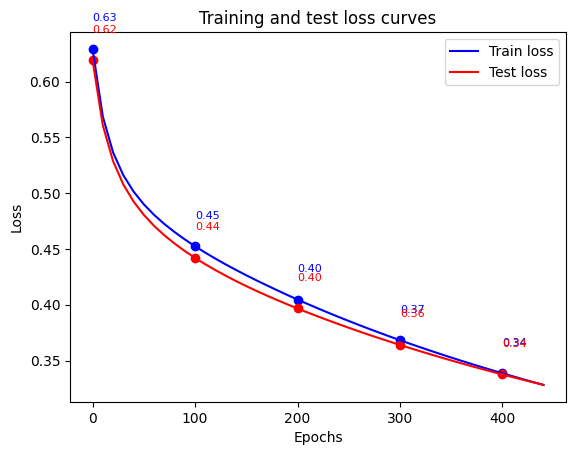

In [20]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss", color='b')
plt.plot(epoch_count, test_loss_values, label="Test loss", color='r')
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Label points that fall on hundreds for train loss and add dots
for i, (x, y) in enumerate(zip(epoch_count, train_loss_values)):
    if x % 100 == 0:  # Only label points that are multiples of 100 on x-axis
        plt.text(x, y + 0.025, f'{y:.2f}', color='b', fontsize=8)  # Label the train loss
        plt.scatter(x, y, color='b')  # Add a dot at the labeled point

# Label points that fall on hundreds for test loss and add dots
for i, (x, y) in enumerate(zip(epoch_count, test_loss_values)):
    if x % 100 == 0:  # Only label points that are multiples of 100 on x-axis
        plt.text(x, y + 0.025, f'{y:.2f}', color='r', fontsize=8)  # Label above the test loss
        plt.scatter(x, y, color='r')  # Add a dot at the labeled point

plt.show()


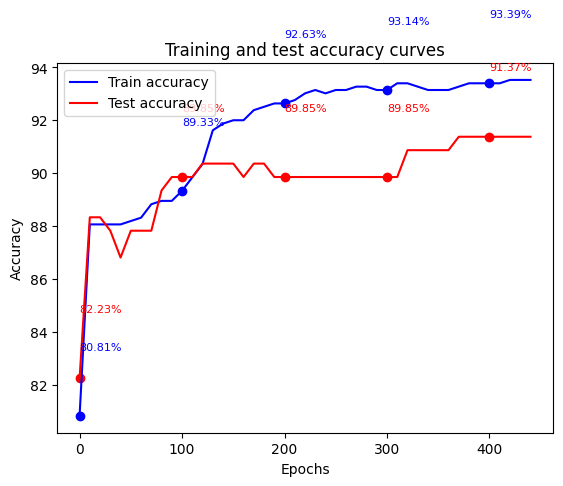

In [21]:
# Plot the accuracy curves
plt.plot(epoch_count, train_acc_values, label="Train accuracy", color='b')
plt.plot(epoch_count, test_acc_values, label="Test accuracy", color='r')
plt.title("Training and test accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Label points that fall on hundreds
for i, (x, y) in enumerate(zip(epoch_count, test_acc_values)):
    if x % 100 == 0:  # Only label points that are multiples of 100 on x-axis
        plt.text(x, y + 2.5, f'{y:.2f}%', color='r', fontsize=8)  # Label the test accuracy
        plt.scatter(x, y, color='r')  # Add a dot at the labeled point

for i, (x, y) in enumerate(zip(epoch_count, train_acc_values)):
    if x % 100 == 0:  # Only label points that are multiples of 100 on x-axis
        plt.text(x, y + 2.5, f'{y:.2f}%', color='b', fontsize=8)  # Label the train accuracy
        plt.scatter(x, y, color='b')  # Add a dot at the labeled point

plt.show()

In [22]:
# # Used to find which epoch count has the best accuracy.
# # Uncomment to use
# throw_away_df = []
# for i, (x, y) in enumerate(zip(epoch_count, test_acc_values)):
#   throw_away_df.append((x,y)) # Appending a tuple (x, y) as a single element

# throw_away_df

In [23]:
print(f"Test accuracy: {test_acc_values[-1]:.2f}%")

Test accuracy: 91.37%


## Model Evaluation

Generally, for classification metrics like precision, recall, and F1-score, scores above 0.80 are considered good, while those below 0.50 are typically poor.

*  Accuracy above 0.90, and Precision, Recall, and F1 scores above 0.80 indicate strong performance in various scenarios.
*  In the context of your Credit Card Fraud Detection model, having high precision and recall is crucial due to the nature of imbalanced datasets and the high cost associated with misclassifying fraudulent transactions. Aiming for scores above 0.80 or even higher would be ideal for a reliable fraud detection system.

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Put model in evaluation mode
model.eval()

with torch.inference_mode():
    # 1. Forward pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate precision, recall, and F1-score
    precision = precision_score(y_test.cpu(), test_pred.cpu())
    recall = recall_score(y_test.cpu(), test_pred.cpu())
    f1 = f1_score(y_test.cpu(), test_pred.cpu())

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

Precision: 0.96
Recall: 0.87
F1-score: 0.91


## Save and load test. Test on randomly selected data.

In [25]:
# Save the model's state_dict to a file
torch.save(model.state_dict(), 'cc_fraud_model.pth')

In [26]:
loaded_model = CC_Fraud_Model(input_features=X_test.shape[1],output_features=1,hidden_units=20)

In [27]:
loaded_model.load_state_dict(torch.load('cc_fraud_model.pth'))

<ipython-input-27-24a21ff599b9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('cc_fraud_model.pth'))


<All keys matched successfully>

In [28]:
# Collect the test data with fraud
fraud_index = torch.where(y_test == 1)[0]

# Get a random index from fraud_index
random_fraud_index = random.choice(fraud_index.tolist())

# Send model to device
loaded_model.to(device)

# Use fraud index in model
loaded_model.eval()
with torch.inference_mode():
    # Forward pass
    y_logits = loaded_model(X_test[random_fraud_index])
    y_pred = torch.round(torch.sigmoid(y_logits))
    if y_test[random_fraud_index] == 1:
        true_fraud_value = "Fraud"
    else:
        true_fraud_value = "Not Fraud"

    if y_pred == 1:
        pre_fraud_value = "Fraud"
    else:
        pre_fraud_value = "Not Fraud"
    print(f'Test index: {random_fraud_index}, Prediction: {pre_fraud_value}, Truth: {true_fraud_value}')

Test index: 89, Prediction: Fraud, Truth: Fraud


In [29]:
# Collect the test data with no fraud
non_fraud_index = torch.where(y_test == 0)[0]

# Get a random index from non_fraud_index
random_non_fraud_index = random.choice(non_fraud_index.tolist())

# Send model to device
loaded_model.to(device)

# Use fraud index in model
loaded_model.eval()
with torch.inference_mode():
    # Forward pass
    y_logits = loaded_model(X_test[random_non_fraud_index])
    y_pred = torch.round(torch.sigmoid(y_logits))
    if y_test[random_non_fraud_index] == 1:
        true_non_fraud_index = "Fraud"
    else:
        true_non_fraud_index = "Not Fraud"

    if y_pred == 1:
        pre_non_fraud_index = "Fraud"
    else:
        pre_non_fraud_index = "Not Fraud"
    print(f'Test index: {random_non_fraud_index}, Prediction: {pre_non_fraud_index}, Truth: {true_non_fraud_index}')

Test index: 127, Prediction: Fraud, Truth: Not Fraud
